In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
import copy
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [3]:
def standard_scalar_normalize(data_train, data_test): 
    scaler = StandardScaler()
    scaler.fit(data_train)
    normal_data_train = scaler.transform(data_train)
    normal_data_test = scaler.transform(data_test)
    return normal_data_train,normal_data_test

In [4]:
def data_processed():
    '''
    Used to read & normalize processed test and train data
    '''
    data_train=pd.read_csv("data/2022-02-07_LOANS_TRAIN.csv")
    data_test=pd.read_csv("data/2022-02-07_LOANS_TEST.csv")
    y_train=data_train['loan_status']
    data_train.drop(columns=['loan_status', 'id', 'issue_d_in_months', 'issue_d_year', 'zip_state_match'], inplace=True)
    
    data_test.drop(columns=['id', 'issue_d_in_months', 'issue_d_year', 'zip_state_match'], inplace=True)
    
    normal_data_train,normal_data_test=standard_scalar_normalize(data_train,data_test)
    return normal_data_train,normal_data_test,y_train

def AUC_score(y_ground_truth,y_predicted_probability):
    return roc_auc_score(y_ground_truth, y_predicted_probability)


In [5]:
X_train_full,X_test,Y_train_full=data_processed()
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, train_size=0.80, random_state=42)

def over_under_sampling(X_train,Y_train,method,fraction):
    if method=="randomU":
        rus = RandomUnderSampler(random_state=0,sampling_strategy=fraction)
    elif method=="randomO":
        rus = RandomOverSampler(random_state=0,sampling_strategy=fraction)
    elif method=="centroid":
        rus = ClusterCentroids(random_state=42,sampling_strategy=fraction)
    elif method=="SMOTENN":
        rus = SMOTEENN(random_state=42,sampling_strategy=fraction)
    X_resampled, y_resampled = rus.fit_resample(X_train, Y_train)
    return X_resampled, y_resampled

X_train, Y_train = over_under_sampling(X_train,Y_train,"randomO",0.95)




## Gradient Boosting Classifier

In [6]:
gb_clf = GradientBoostingClassifier(max_depth=3, n_estimators=250, random_state=0)
gb_clf.fit(X_train, Y_train)
Y_train_pred_gb=gb_clf.predict(X_train)
Y_val_pred_gb=gb_clf.predict(X_val)
Y_val_pred_prob_gb=gb_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_gb)

0.6913462746991128

In [7]:
Y_train_pred_prob_gb=gb_clf.predict_proba(X_train)[:,1]


In [8]:
confusion_matrix(Y_val,Y_val_pred_gb)

array([[21765, 11583],
       [ 2302,  3800]])

In [9]:
np.std(Y_val_pred_prob_gb)

0.16640214175506088

## LGBM Classifier

In [10]:
lgbm_clf = LGBMClassifier(class_weight='balanced', max_depth=14, min_child_samples=75, n_estimators=100)
lgbm_clf.fit(X_train, Y_train)
Y_train_pred_lgbm=lgbm_clf.predict(X_train)
Y_val_pred_lgbm=lgbm_clf.predict(X_val)
Y_val_pred_prob_lgbm=lgbm_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_lgbm)

0.69151399834417

In [11]:
Y_train_pred_prob_lgbm=lgbm_clf.predict_proba(X_train)[:,1]


In [12]:
confusion_matrix(Y_val,Y_val_pred_lgbm)

array([[21071, 12277],
       [ 2172,  3930]])

In [13]:
np.std(Y_val_pred_prob_lgbm)

0.17020682236100104

In [14]:
lgbm_clf2 = LGBMClassifier(class_weight='balanced', max_depth=5, min_child_samples=65, n_estimators=120)
lgbm_clf2.fit(X_train, Y_train)
Y_train_pred_lgbm2=lgbm_clf2.predict(X_train)
Y_val_pred_lgbm2=lgbm_clf2.predict(X_val)
Y_val_pred_prob_lgbm2=lgbm_clf2.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_lgbm2)

0.6930596358644479

In [15]:
Y_train_pred_prob_lgbm2=lgbm_clf2.predict_proba(X_train)[:,1]


In [16]:
confusion_matrix(Y_val,Y_val_pred_lgbm2)

array([[21095, 12253],
       [ 2170,  3932]])

## Random Forest Classifier 

In [17]:
rf_clf = RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=25, n_estimators=400)
rf_clf.fit(X_train, Y_train)
Y_train_pred_rf=rf_clf.predict(X_train)
Y_val_pred_rf=rf_clf.predict(X_val)
Y_val_pred_prob_rf=rf_clf.predict_proba(X_val)[:,1]
roc_auc_score(Y_val,Y_val_pred_prob_rf)

0.6900207713915611

In [18]:
Y_train_pred_prob_rf=rf_clf.predict_proba(X_train)[:,1]


In [19]:
confusion_matrix(Y_val,Y_val_pred_rf)

array([[24553,  8795],
       [ 2928,  3174]])

In [20]:
np.std(Y_val_pred_prob_rf)

0.14235348045355725

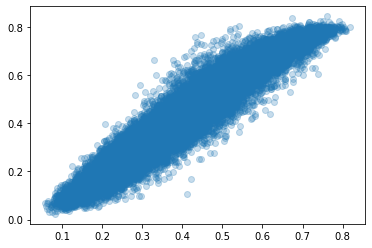

In [21]:
plt.scatter(Y_val_pred_prob_rf, Y_val_pred_prob_lgbm, alpha=0.25)


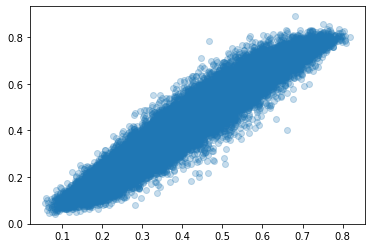

In [22]:
plt.scatter(Y_val_pred_prob_rf, Y_val_pred_prob_gb, alpha=0.25)


## Use average voting

In [38]:
Y_average = np.mean([Y_val_pred_prob_lgbm,Y_val_pred_prob_rf,Y_val_pred_prob_gb, Y_val_pred_prob_lgbm2], axis=0)

print(AUC_score(Y_val,Y_average))

Y_average[Y_average>=0.5] = 1
Y_average[Y_average<0.5] = 0
confusion_matrix(Y_val,Y_average)

0.6935576763136707


array([[22094, 11254],
       [ 2354,  3748]])

## Try classweights rather than oversampling

In [41]:
X_train_nosamp, X_val_nosamp, Y_train_nosamp, Y_val_nosamp = train_test_split(X_train_full, Y_train_full, train_size=0.80, random_state=42)

gb_clf_cw = GradientBoostingClassifier(max_depth=3, n_estimators=250, random_state=0)
gb_clf_cw.fit(X_train_nosamp, Y_train_nosamp, sample_weight=copy.deepcopy(Y_train_nosamp)*4 + 1)
Y_val_pred_prob_gb_cw=gb_clf_cw.predict_proba(X_val_nosamp)[:,1]


lgbm_clf_cw = LGBMClassifier(class_weight='balanced', max_depth=14, min_child_samples=75, n_estimators=100)
lgbm_clf_cw.fit(X_train_nosamp, Y_train_nosamp)
Y_val_pred_prob_lgbm_cw=lgbm_clf_cw.predict_proba(X_val_nosamp)[:,1]

lgbm_clf_cw2 = LGBMClassifier(class_weight='balanced', max_depth=5, min_child_samples=65, n_estimators=120)
lgbm_clf_cw2.fit(X_train_nosamp, Y_train_nosamp)
Y_val_pred_prob_lgbm_cw2=lgbm_clf_cw2.predict_proba(X_val_nosamp)[:,1]


rf_clf_cw = RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=25, n_estimators=400)
rf_clf_cw.fit(X_train_nosamp, Y_train_nosamp)
Y_val_pred_prob_rf_cw=rf_clf_cw.predict_proba(X_val_nosamp)[:,1]

val_probs = [Y_val_pred_prob_gb_cw,Y_val_pred_prob_lgbm_cw, Y_val_pred_prob_lgbm_cw2, Y_val_pred_prob_rf_cw]


In [42]:
Y_val_average = np.mean(val_probs, axis=0)
roc_auc_score(Y_val_nosamp,Y_val_average)

0.6938637854801115

## Output to submission

In [45]:
gb_clf_full = GradientBoostingClassifier(max_depth=3, n_estimators=250, random_state=0)
gb_clf_full.fit(X_train_full, Y_train_full, sample_weight=copy.deepcopy(Y_train_full)*4 + 1)
Y_test_pred_prob_gb=gb_clf_full.predict_proba(X_test)[:,1]


lgbm_clf_full = LGBMClassifier(class_weight='balanced', max_depth=14, min_child_samples=75, n_estimators=100)
lgbm_clf_full.fit(X_train_full, Y_train_full)
Y_test_pred_prob_lgbm=lgbm_clf_full.predict_proba(X_test)[:,1]

lgbm_clf_full2 = LGBMClassifier(class_weight='balanced', max_depth=5, min_child_samples=65, n_estimators=120)
lgbm_clf_full2.fit(X_train_full, Y_train_full)
Y_test_pred_prob_lgbm2=lgbm_clf_full2.predict_proba(X_test)[:,1]


rf_clf_full = RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=25, n_estimators=400)
rf_clf_full.fit(X_train_full, Y_train_full)
Y_test_pred_prob_rf=rf_clf_full.predict_proba(X_test)[:,1]

test_probs = [Y_test_pred_prob_lgbm,Y_test_pred_prob_rf, Y_test_pred_prob_gb, Y_test_pred_prob_lgbm2]



In [46]:
def to_submission(ids, y_test_predicted_probability):
    y_test=pd.DataFrame(y_test_predicted_probability,columns=['loan_status'], index=ids)
    y_test.index.name = 'id'
    y_test.to_csv('data/submission.csv')
    return

Y_test_average = np.mean(test_probs, axis=0)
to_submission(pd.read_csv("data/2022-02-07_LOANS_TEST.csv")['id'].values, Y_test_average)